# 1. Import Libraries and Load Files

In [1]:
# basic
import pandas as pd
import numpy as np

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import category_encoders as ce
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
import optuna
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ETC
from collections import Counter
from scipy.stats import ttest_ind
import ast

In [2]:
import random
import os

SEED = 22
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
df = pd.read_csv('../datasets/business6.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19534 entries, 0 to 19533
Data columns (total 92 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   business_id          19534 non-null  object 
 1   name                 19534 non-null  object 
 2   address              19467 non-null  object 
 3   city                 19534 non-null  object 
 4   state                19534 non-null  object 
 5   postal_code          19532 non-null  float64
 6   latitude             19534 non-null  float64
 7   longitude            19534 non-null  float64
 8   stars                19534 non-null  float64
 9   review_count         19534 non-null  int64  
 10  is_open              19534 non-null  int64  
 11  attributes           19527 non-null  object 
 12  categories           19534 non-null  object 
 13  hours                18432 non-null  object 
 14  store_status         19534 non-null  object 
 15  c_nightlife          19534 non-null 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19534 entries, 0 to 19533
Data columns (total 92 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   business_id          19534 non-null  object 
 1   name                 19534 non-null  object 
 2   address              19467 non-null  object 
 3   city                 19534 non-null  object 
 4   state                19534 non-null  object 
 5   postal_code          19532 non-null  float64
 6   latitude             19534 non-null  float64
 7   longitude            19534 non-null  float64
 8   stars                19534 non-null  float64
 9   review_count         19534 non-null  int64  
 10  is_open              19534 non-null  int64  
 11  attributes           19527 non-null  object 
 12  categories           19534 non-null  object 
 13  hours                18432 non-null  object 
 14  store_status         19534 non-null  object 
 15  c_nightlife          19534 non-null 

# 2. Preprocessing for ML

### (1) Select Columns for ML

In [6]:

exclude_cols = [

    # basic restaurant information
    'business_id', 'name', 'attributes', 'categories', 'hours',

    # location information
    'address', 'city', 'postal_code', 'latitude', 'longitude',

    # business hours information
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',

            ]

df = df.drop(columns=exclude_cols)

### (2) Convert data types

In [7]:
# -------------------------
# 1. Convert object → int (Boolean Encoding)
# -------------------------

# Columns to convert from string values ("True"/"False") to integer (0/1)
bool_cols = ['a_outdoor_seating', 'a_good_for_group', 'a_good_for_kids', 'a_has_tv', 'a_happy_hour']

# Helper function to convert string boolean values to integer format
def str_to_int_bool(x):
    if pd.isna(x):
        return np.nan   # Keep missing values as NaN (optionally replace with 0 if needed)
    elif str(x).strip().lower() == 'true':
        return 1
    elif str(x).strip().lower() == 'false':
        return 0
    else:
        return np.nan

# Apply conversion to each column and cast to pandas' nullable integer type
for col in bool_cols:
    df[col] = df[col].apply(str_to_int_bool).astype('Int64')

In [8]:
# -------------------------
# 2. Ordinal Mapping for Noise Level
# -------------------------

# Define the ordered scale: quiet < average < loud < very_loud
noise_mapping = {
    'quiet': 0,
    'average': 1,
    'loud': 2,
    'very_loud': 3
}

# Apply the ordinal mapping
df['a_noise_level'] = df['a_noise_level'].map(noise_mapping)


### (3) Impute missing values

In [9]:
# -------------------------
# 1. a_outdoor_seating ~ a_happy_hour
# -------------------------

# Treat missing values as 0 (meaning the feature does not apply)
cols_bool = ['a_outdoor_seating', 'a_good_for_group', 'a_good_for_kids', 'a_has_tv', 'a_happy_hour']

df[cols_bool] = df[cols_bool].fillna(0).astype(int)

In [10]:
# -------------------------
# 2. a_alcohol
# -------------------------

# Assign a default value based on nightlife classification
df['a_alcohol'] = np.where(
    df['a_alcohol'].isna(),                                 
    np.where(df['c_nightlife'] == 1, 'full_bar', 'none'),   # If the business is nightlife-focused → assume full bar, otherwise none
    df['a_alcohol']                                         
)

In [11]:
# -------------------------
# 3. a_ambience
# -------------------------

# Replace missing ambience values with 'unknown'
df['a_ambience'] = df['a_ambience'].fillna('unknown')

### (4) Remove Outliers

In [12]:
# Remove businesses with zero total operating hours

# Record dataset size before filtering
before_count = len(df)

# Filter out rows where total_weekly_hours is zero
df = df[df['total_weekly_hours'] > 0].copy()

# Report how many records were removed
after_count = len(df)
removed = before_count - after_count
print(f"Removed {removed} records ({removed / before_count:.2%})")


Removed 1480 records (7.58%)


### (5) Log Transformation

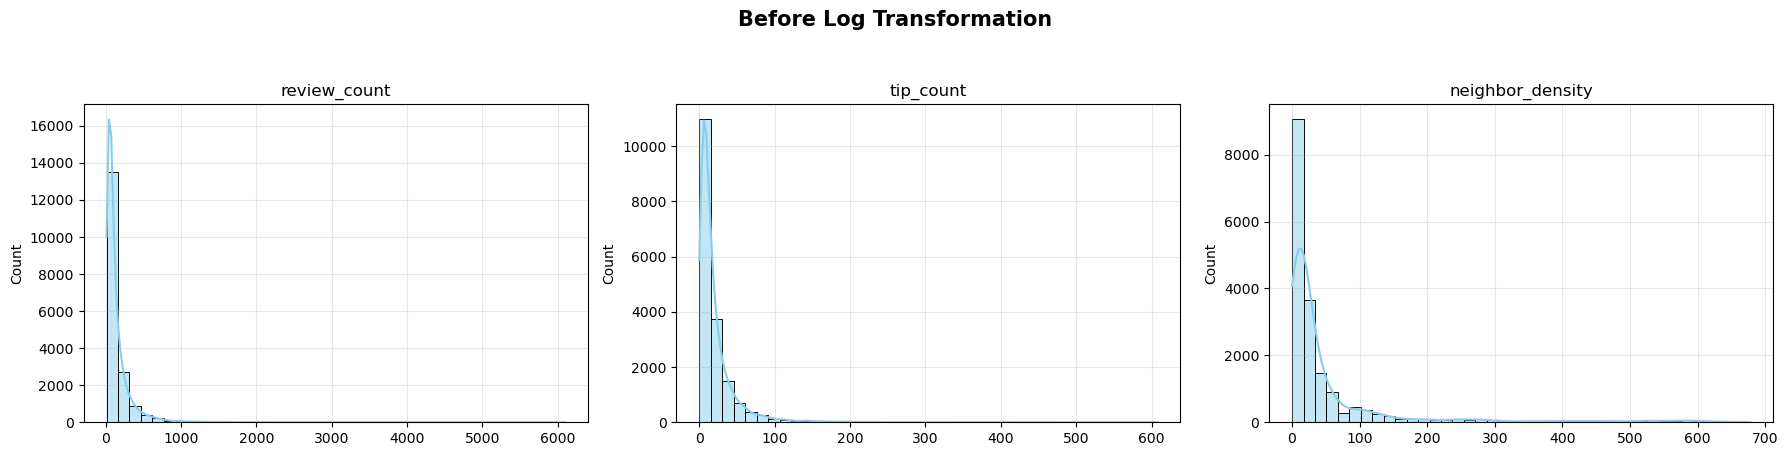

In [13]:
# Columns selected for log transformation
cols_to_log = [
    'review_count',
    'tip_count',
    'neighbor_density'
]

# Visualization (before log transformation)
plt.figure(figsize=(18, 8))
plt.suptitle("Before Log Transformation", fontsize=15, fontweight="bold")

for i, col in enumerate(cols_to_log, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=40, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel('')
    plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
# Apply log transformation with clipping to avoid negative values
for col in cols_to_log:
    df[col] = np.log1p(df[col].clip(lower=0))


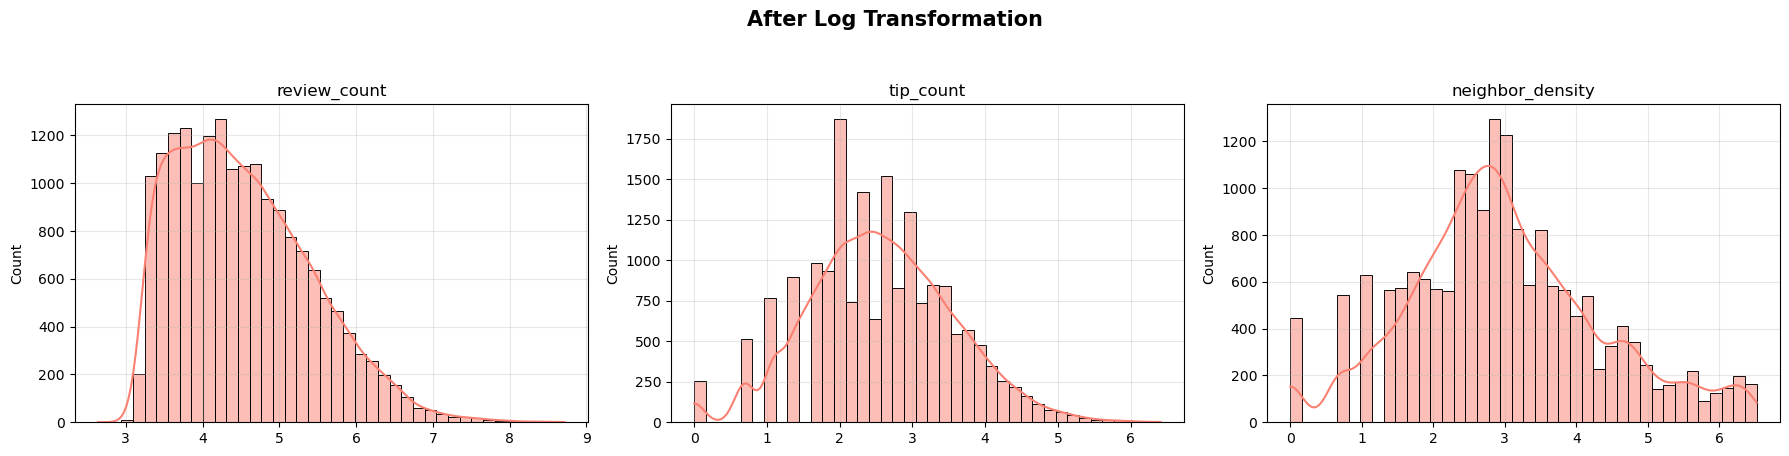

In [15]:
# Visualization (after log transformation)
plt.figure(figsize=(18, 8))
plt.suptitle("After Log Transformation", fontsize=15, fontweight="bold")

for i, col in enumerate(cols_to_log, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=40, kde=True, color='salmon')
    plt.title(f'{col}')
    plt.xlabel('')
    plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 3. Machine Learning

In [16]:
# -------------------------
# 1. Split data into train and test sets
# -------------------------

X = df.drop("loyalty_score", axis=1)
y = df["loyalty_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [17]:
# -------------------------
# 2. Impute missing values
# -------------------------

# --- (1) a_price_range ---
# List of category indicator columns
cat_cols = [
    'c_nightlife', 'c_cafes', 'c_brunch', 'c_sandwich', 'c_american_trad', 'c_american_new',
    'c_italian', 'c_burgers', 'c_mexican', 'c_seafood', 'c_fastfood',
    'c_asian_fusion', 'c_bakeries', 'c_dietary', 'c_other'
]

# Compute median price_range per category based on the training data
cat_medians_train = {
    c: X_train.loc[X_train[c] == 1, 'a_price_range'].median()
    for c in cat_cols
}

# Overall median from the training set (used as fallback)
overall_median = X_train['a_price_range'].median()

# Function to impute missing price_range values
def fill_price(row, cat_medians, overall_median):
    if pd.notna(row['a_price_range']):
        return row['a_price_range']
    
    # Find categories that apply to this business
    cats = [c for c in cat_cols if row[c] == 1]
    vals = [cat_medians[c] for c in cats if not np.isnan(cat_medians[c])]
    
    # If no valid category median exists, use overall median
    if len(vals) == 0:
        val = overall_median
    # If only one category median is available, use it
    elif len(vals) == 1:
        val = vals[0]
    # If multiple medians exist, take the average
    else:
        val = np.mean(vals)
    
    return round(val)

# Apply imputation to training and test sets
X_train['a_price_range'] = X_train.apply(
    fill_price, axis=1, args=(cat_medians_train, overall_median)
).astype(int)

X_test['a_price_range'] = X_test.apply(
    fill_price, axis=1, args=(cat_medians_train, overall_median)  # Use statistics from the training set
).astype(int)


In [18]:
# --- (2) a_noise_level ---

# Compute median noise_level per category based on the training data
cat_medians_train = {
    c: X_train.loc[X_train[c] == 1, 'a_noise_level'].median()
    for c in cat_cols
}

# Overall median from the training set (used as fallback)
overall_median = X_train['a_noise_level'].median()

# Function to impute missing noise_level values
def fill_noise(row, cat_medians, overall_median):
    if pd.notna(row['a_noise_level']):
        return row['a_noise_level']
    
    # Find categories that apply to this business
    cats = [c for c in cat_cols if row[c] == 1]
    vals = [cat_medians[c] for c in cats if not np.isnan(cat_medians[c])]
    
    # If no valid category median exists, use overall median
    if len(vals) == 0:
        val = overall_median
    # If only one category median is available, use it
    elif len(vals) == 1:
        val = vals[0]
    # If multiple medians exist, take the average
    else:
        val = np.mean(vals)
    
    return round(val)

# Apply imputation to training and test sets
X_train['a_noise_level'] = X_train.apply(
    fill_noise, axis=1, args=(cat_medians_train, overall_median)
).astype(int)

X_test['a_noise_level'] = X_test.apply(
    fill_noise, axis=1, args=(cat_medians_train, overall_median)  # Use statistics from the training set only
).astype(int)

In [19]:
# --- (3) neighbor_avg_stars ---

# Compute the mean value from the training set
mean_neighbor_stars = X_train['neighbor_avg_stars'].mean()

# Impute missing values using the same mean (train-based)
X_train['neighbor_avg_stars'] = X_train['neighbor_avg_stars'].fillna(mean_neighbor_stars)
X_test['neighbor_avg_stars'] = X_test['neighbor_avg_stars'].fillna(mean_neighbor_stars)

In [20]:
# -----------------------------
# 3. Target Encoding
# -----------------------------

# categorical columns only
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

encoder = ce.CatBoostEncoder(cols=cat_cols)
X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc = encoder.transform(X_test)

In [21]:
# -----------------------------
# 4. Scaling (numeric only)
# -----------------------------

num_cols = X_train_enc.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
X_test_enc[num_cols] = scaler.transform(X_test_enc[num_cols])

In [22]:
# -----------------------------
# 5. Evaluate baseline model performance
# -----------------------------
# Define baseline models
SEED = 22
models = {
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=SEED),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(random_state=SEED, n_jobs=1),
    "AdaBoost": AdaBoostRegressor(random_state=SEED),
    "Gradient Boost": GradientBoostingRegressor(random_state=SEED),
    "XGBoost": XGBRegressor(random_state=SEED, verbosity=0, n_jobs=1, deterministic=True),
    "LightGBM": LGBMRegressor(random_state=SEED, n_jobs=1, deterministic=True),
    "CatBoost": CatBoostRegressor(random_state=SEED, verbose=0, thread_count=1)
}

# Evaluate model performance
results = []
for name, model in models.items():
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2})

# Results DataFrame
results_df = (
    pd.DataFrame(results)
    .sort_values(by="MAE", ascending=True)
    .reset_index(drop=True)
)

display(results_df.style.format({"RMSE": "{:,.2f}", "MAE": "{:,.2f}", "R²": "{:.4f}"}))

c:\Users\toomu\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\toomu\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\toomu\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\toomu\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3928
[LightGBM] [Info] Number of data points in the train set: 14443, number of used features: 74
[LightGBM] [Info] Start training from score 56.513082


,Model,RMSE,MAE,R²
0,CatBoost,4.66,3.56,0.6953
1,LightGBM,4.65,3.57,0.6962
2,Gradient Boost,4.66,3.58,0.6956
3,Random Forest,4.72,3.63,0.6870
4,SVM,4.85,3.73,0.6697
5,XGBoost,4.87,3.74,0.6673
6,AdaBoost,5.15,4.11,0.6283
7,KNN,6.00,4.72,0.4943
8,Decision Tree,6.94,5.31,0.3239


In [ ]:
# -------------------------
# 6. Hyperparameter tuning
# -------------------------

# Define an objective function
def objective_cat(trial):
    # Suggest hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "loss_function": "MAE",
        "verbose": 0,
        "random_state": 22
    }

    # Define model
    model = CatBoostRegressor(**params)

    # Fit model
    model.fit(X_train_enc, y_train, eval_set=(X_test_enc, y_test), verbose=0)

    # Predict
    y_pred = model.predict(X_test_enc)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Run optimization
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=100, show_progress_bar=True)

# Show best results
print("Best MAE:", study_cat.best_value)
print("Best Parameters:", study_cat.best_params)

# Train final model
best_params_cat = study_cat.best_params
best_params_cat["loss_function"] = "MAE"
best_cat = CatBoostRegressor(**best_params_cat)
best_cat.fit(X_train_enc, y_train)

# Predict and evaluate on test data
y_pred = best_cat.predict(X_test_enc)

print("\n===== CatBoost (Optimized) =====")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

In [24]:
# -------------------------
# 7. Set base models with best params
# -------------------------

final_cat = CatBoostRegressor(
    iterations = 779, 
    depth = 5, 
    learning_rate = 0.04889646224788982, 
    l2_leaf_reg = 6.849937304481644, 
    bagging_temperature = 0.7777828138602021, 
    random_strength = 0.2438828382824005, 
    border_count = 254, 
    subsample = 0.9578893653016715,
    loss_function = "MAE"
)

# Train final cat model
final_cat.fit(X_train_enc, y_train)

# Predict and evaluate on test data
y_pred = final_cat.predict(X_test_enc)

print("\n===== CatBoost (Optimized) =====")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

0:	learn: 6.6225818	total: 10.1ms	remaining: 7.85s
1:	learn: 6.4413434	total: 17.2ms	remaining: 6.67s
2:	learn: 6.2745137	total: 27.2ms	remaining: 7.04s
3:	learn: 6.1159839	total: 34.4ms	remaining: 6.66s
4:	learn: 5.9680617	total: 42.5ms	remaining: 6.57s
5:	learn: 5.8286486	total: 48.4ms	remaining: 6.23s
6:	learn: 5.6997556	total: 55.5ms	remaining: 6.12s
7:	learn: 5.5846796	total: 61.7ms	remaining: 5.95s
8:	learn: 5.4709151	total: 67.9ms	remaining: 5.81s
9:	learn: 5.3667822	total: 74.7ms	remaining: 5.74s
10:	learn: 5.2690371	total: 80.7ms	remaining: 5.63s
11:	learn: 5.1735732	total: 88ms	remaining: 5.62s
12:	learn: 5.0887909	total: 93.7ms	remaining: 5.52s
13:	learn: 5.0060724	total: 99.9ms	remaining: 5.46s
14:	learn: 4.9262977	total: 107ms	remaining: 5.47s
15:	learn: 4.8529546	total: 114ms	remaining: 5.43s
16:	learn: 4.7840515	total: 121ms	remaining: 5.44s
17:	learn: 4.7213226	total: 127ms	remaining: 5.38s
18:	learn: 4.6619159	total: 135ms	remaining: 5.38s
19:	learn: 4.6043817	total: 1

# 4. Model Insights

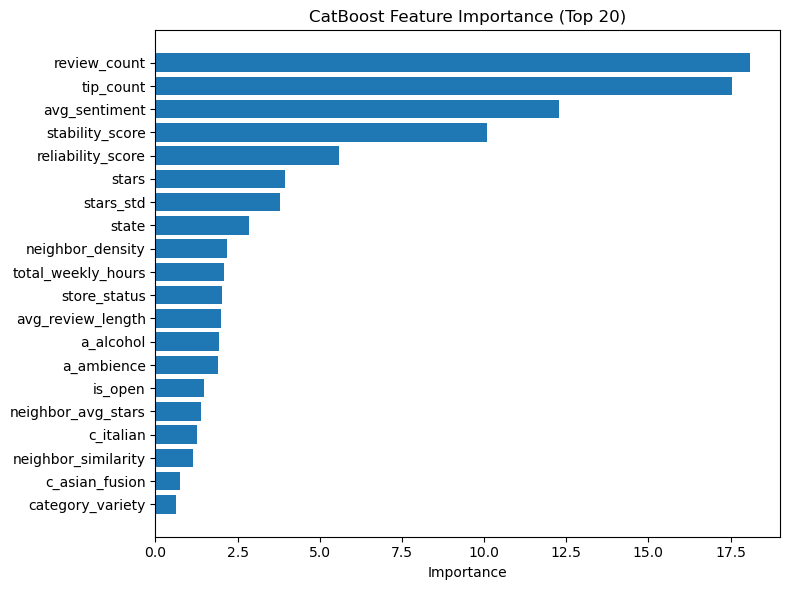

In [25]:
# -------------------------
# 1. feature importance
# -------------------------

# Get feature importance values
importances = final_cat.get_feature_importance()
features = X_train.columns  # use the same feature order as training data

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(8,6))
plt.barh(importance_df["Feature"].head(20)[::-1], importance_df["Importance"].head(20)[::-1])
plt.title("CatBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


C:\Users\toomu\AppData\Local\Temp\ipykernel_11868\19044163.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


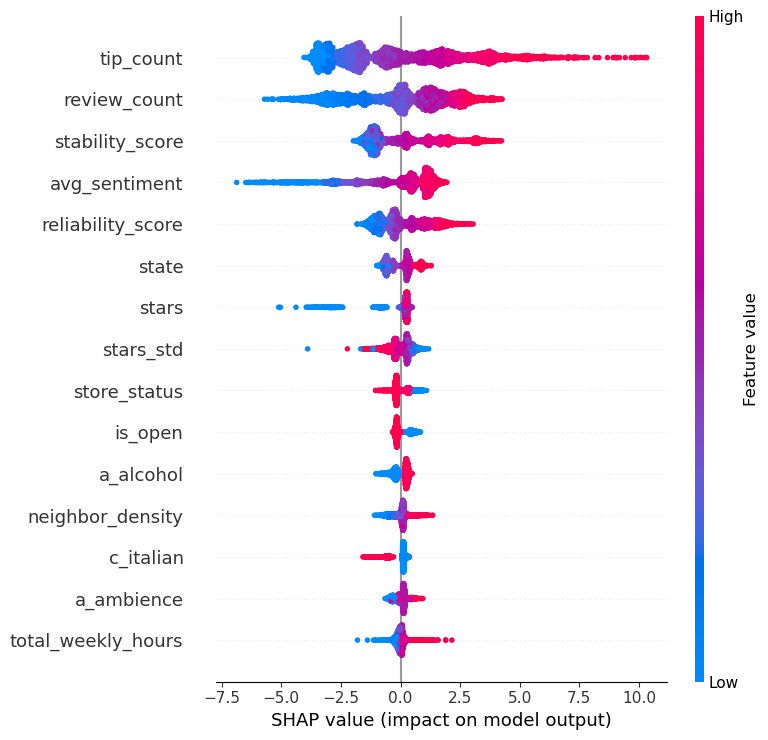

In [26]:
# -------------------------
# 2. SHAP value
# -------------------------

# SHAP for CatBoost
if not isinstance(X_test_enc, pd.DataFrame):
    X_test_enc = pd.DataFrame(X_test_enc, columns=X_test.columns)

explainer = shap.TreeExplainer(final_cat)
shap_values = explainer.shap_values(X_test_enc)

# Summary plot with feature names
shap.summary_plot(
    shap_values,
    X_test_enc, 
    max_display=15,
    show=True
)

C:\Users\toomu\AppData\Local\Temp\ipykernel_11868\1795740339.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


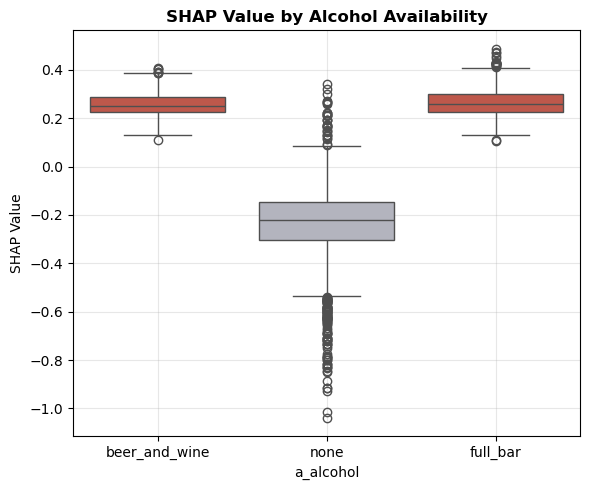

🔹 Highlighted category: none


In [27]:
# -------------------------
# 3. Detailed SHAP Value Analysis
# -------------------------

# --- (1) a_alcohol ---
cat_col = 'a_alcohol'
shap_col_idx = X_test.columns.get_loc(cat_col)

# Build a DataFrame for SHAP inspection
shap_df = pd.DataFrame({
    cat_col: X_test[cat_col],
    'SHAP Value': shap_values[:, shap_col_idx]
})

# Compute mean SHAP value per category
mean_shap = shap_df.groupby(cat_col)['SHAP Value'].mean()

# Identify the category with the highest impact
highlight_cat = mean_shap.idxmin()

# Assign highlight color only to the top category
colors = [ '#b1b3c0' if cat == highlight_cat else '#d14938'
           for cat in shap_df[cat_col].unique() ]

# Boxplot visualization
plt.figure(figsize=(6,5))
sns.boxplot(
    data=shap_df,
    x=cat_col,
    y='SHAP Value',
    palette=colors
)

# Formatting
plt.title(f"SHAP Value by Alcohol Availability", fontsize=12, weight='bold')
plt.xlabel(cat_col)
plt.ylabel("SHAP Value")
# plt.xticks(rotation=30)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"🔹 Highlighted category: {highlight_cat}")

C:\Users\toomu\AppData\Local\Temp\ipykernel_11868\1233625780.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


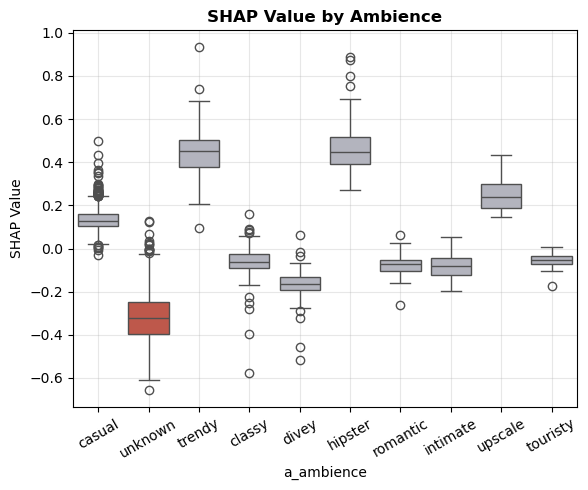

🔹 Highlighted (lowest) category: unknown


In [28]:
# --- (2) a_ambience ---
cat_col = 'a_ambience'
shap_col_idx = X_test.columns.get_loc(cat_col)

# Build a DataFrame for SHAP inspection
shap_df = pd.DataFrame({
    cat_col: X_test[cat_col],
    'SHAP Value': shap_values[:, shap_col_idx]
})

# Compute mean SHAP value per category
mean_shap = shap_df.groupby(cat_col)['SHAP Value'].mean()

# Identify the category with the lowest impact
highlight_cat = mean_shap.idxmin()

# Assign highlight color only to the top category
colors = [
    '#d14938' if cat == highlight_cat else '#b1b3c0'
    for cat in shap_df[cat_col].unique()
]

# Boxplot visualization
order = mean_shap.sort_values(ascending=False).index
plt.figure(figsize=(6,5))
sns.boxplot(
    data=shap_df,
    x=cat_col,
    y='SHAP Value',
    palette=colors
)

# Formatting
plt.title(f"SHAP Value by Ambience", fontsize=12, weight='bold')
# plt.xlabel("Ambience Type")
plt.ylabel("SHAP Value")
plt.xticks(rotation=30)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"🔹 Highlighted (lowest) category: {highlight_cat}")